In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os_path = '/content/drive/MyDrive'

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/datasets')

In [ ]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores,pff

from model import FixCapsNet

In [ ]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}

#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [ ]:
def get_data(trans_test='312'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((302,302)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os_path,""))  # get data root path
    image_path = os.path.join(data_root,"datasets", "HAM100000")#
    print(image_path)
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [ ]:
BatchSize = 168
V_size = 40 
T_size = 32 
train_doc = "train525e384"
val_doc = "val525e384png"
test_doc = "test525png384"

nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 6 dataloader workers every process.
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.


In [ ]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 141, 141]         124,544
              ReLU-2        [-1, 128, 141, 141]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [ ]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(18, 18), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [ ]:
dsize = (1, 3, 299, 299)
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps"+'-'+mode,model=network,inputes=input_data)

+-------------+-----------+----------+------+
|    Model    | Params(M) | FLOPs(G) | FPS  |
+-------------+-----------+----------+------+
| FixCaps-128 |    0.26   |   2.48   | 65.3 |
+-------------+-----------+----------+------+


In [ ]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()     
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [ ]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
                torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    

In [ ]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    !mkdir -p ./tmp/{img_title}/{suf} 
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:0507_033609
./tmp/HAM10000/0507_033609/best_HAM10000_0507_033609.pth


In [ ]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)


In [ ]:
num_epochs = 120

In [ ]:
for epoch in range(1, num_epochs + 1): #4h 26m 46s
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.38553,ACC:0.32549
Train Epoch:[1] Loss:0.39971,Acc:0.38131,Best_train:0.38131
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:52.982%
Best_val:[52.982%]
[Train Epoch:[2]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.32291,ACC:0.47503
Train Epoch:[2] Loss:0.33651,Acc:0.48726,Best_train:0.48726
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:66.203%
Best_val:[66.203%]
[Train Epoch:[3]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29936,ACC:0.52423
Train Epoch:[3] Loss:0.31188,Acc:0.52881,Best_train:0.52881
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:70.08%
Best_val:[70.08%]
[Train Epoch:[4]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28133,ACC:0.54893
Train Epoch:[4] Loss:0.29726,Acc:0.55328,Best_train:0.55328
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.062%
Best_val:[73.062%]
[Train Epoch:[5]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27980,ACC:0.57421
Train Epoch:[5] Loss:0.28682,Acc:0.57254,Best_train:0.57254
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:72.565%
Best_val:[73.062%]
[Train Epoch:[6]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28235,ACC:0.57738
Train Epoch:[6] Loss:0.28562,Acc:0.57391,Best_train:0.57391
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.459%
Best_val:[73.459%]
[Train Epoch:[7]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28937,ACC:0.56977
Train Epoch:[7] Loss:0.28421,Acc:0.57563,Best_train:0.57563
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:75.249%
Best_val:[75.249%]
[Train Epoch:[8]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27565,ACC:0.56981
Train Epoch:[8] Loss:0.28565,Acc:0.57186,Best_train:0.57563
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:72.465%
Best_val:[75.249%]
[Train Epoch:[9]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26514,ACC:0.56818
Train Epoch:[9] Loss:0.28623,Acc:0.57412,Best_train:0.57563
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.26%
Best_val:[75.249%]
[Train Epoch:[10]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26377,ACC:0.57491
Train Epoch:[10] Loss:0.28273,Acc:0.57956,Best_train:0.57956
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.155%
Best_val:[75.249%]
[Train Epoch:[11]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.30749,ACC:0.58411
Train Epoch:[11] Loss:0.27810,Acc:0.58746,Best_train:0.58746
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:72.465%
Best_val:[75.249%]
[Train Epoch:[12]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24600,ACC:0.60150
Train Epoch:[12] Loss:0.27046,Acc:0.60123,Best_train:0.60123
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.237%
Best_val:[77.237%]
[Train Epoch:[13]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27757,ACC:0.61696
Train Epoch:[13] Loss:0.26137,Acc:0.61567,Best_train:0.61567
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:75.05%
Best_val:[77.237%]
[Train Epoch:[14]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23519,ACC:0.62883
Train Epoch:[14] Loss:0.25333,Acc:0.63183,Best_train:0.63183
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.821%
Best_val:[79.821%]
[Train Epoch:[15]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24955,ACC:0.63949
Train Epoch:[15] Loss:0.24648,Acc:0.64428,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.517%
Best_val:[80.517%]
[Train Epoch:[16]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26263,ACC:0.64100
Train Epoch:[16] Loss:0.24685,Acc:0.63911,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.622%
Best_val:[80.517%]
[Train Epoch:[17]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25195,ACC:0.64460
Train Epoch:[17] Loss:0.24617,Acc:0.64327,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.33%
Best_val:[80.517%]
[Train Epoch:[18]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27025,ACC:0.63934
Train Epoch:[18] Loss:0.24894,Acc:0.63700,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.038%
Best_val:[80.517%]
[Train Epoch:[19]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24466,ACC:0.63250
Train Epoch:[19] Loss:0.25159,Acc:0.63501,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:75.05%
Best_val:[80.517%]
[Train Epoch:[20]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.26730,ACC:0.63227
Train Epoch:[20] Loss:0.25383,Acc:0.63290,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.429%
Best_val:[80.517%]
[Train Epoch:[21]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25659,ACC:0.63389
Train Epoch:[21] Loss:0.25299,Acc:0.63280,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.429%
Best_val:[80.517%]
[Train Epoch:[22]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23593,ACC:0.64100
Train Epoch:[22] Loss:0.24799,Acc:0.64171,Best_train:0.64428
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.815%
Best_val:[80.815%]
[Train Epoch:[23]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23646,ACC:0.65140
Train Epoch:[23] Loss:0.24118,Acc:0.65206,Best_train:0.65206
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:69.284%
Best_val:[80.815%]
[Train Epoch:[24]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23215,ACC:0.66013
Train Epoch:[24] Loss:0.23460,Acc:0.66358,Best_train:0.66358
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.897%
Best_val:[83.897%]
[Train Epoch:[25]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20895,ACC:0.67525
Train Epoch:[25] Loss:0.22920,Acc:0.67375,Best_train:0.67375
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.803%
Best_val:[83.897%]
[Train Epoch:[26]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21072,ACC:0.67764
Train Epoch:[26] Loss:0.22815,Acc:0.67595,Best_train:0.67595
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.294%
Best_val:[84.294%]
[Train Epoch:[27]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22592,ACC:0.67571
Train Epoch:[27] Loss:0.22828,Acc:0.67696,Best_train:0.67696
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.002%
Best_val:[84.294%]
[Train Epoch:[28]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22413,ACC:0.66933
Train Epoch:[28] Loss:0.23229,Acc:0.66805,Best_train:0.67696
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[86.084%]
[Train Epoch:[29]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21879,ACC:0.66307
Train Epoch:[29] Loss:0.23639,Acc:0.66261,Best_train:0.67696
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.909%
Best_val:[86.084%]
[Train Epoch:[30]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23630,ACC:0.65909
Train Epoch:[30] Loss:0.23838,Acc:0.66145,Best_train:0.67696
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.002%
Best_val:[86.084%]
[Train Epoch:[31]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19202,ACC:0.65534
Train Epoch:[31] Loss:0.23915,Acc:0.65928,Best_train:0.67696
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.809%
Best_val:[86.084%]
[Train Epoch:[32]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22063,ACC:0.66589
Train Epoch:[32] Loss:0.23462,Acc:0.66600,Best_train:0.67696
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[86.084%]
[Train Epoch:[33]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21136,ACC:0.67687
Train Epoch:[33] Loss:0.22861,Acc:0.67785,Best_train:0.67785
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[86.084%]
[Train Epoch:[34]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22802,ACC:0.68425
Train Epoch:[34] Loss:0.22266,Acc:0.68557,Best_train:0.68557
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.897%
Best_val:[86.084%]
[Train Epoch:[35]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21706,ACC:0.69685
Train Epoch:[35] Loss:0.21670,Acc:0.69711,Best_train:0.69711
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[86.084%]
[Train Epoch:[36]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20175,ACC:0.70037
Train Epoch:[36] Loss:0.21556,Acc:0.69862,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[86.084%]
[Train Epoch:[37]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22405,ACC:0.69550
Train Epoch:[37] Loss:0.21601,Acc:0.69777,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[86.084%]
[Train Epoch:[38]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20862,ACC:0.69202
Train Epoch:[38] Loss:0.21871,Acc:0.69380,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.406%
Best_val:[86.084%]
[Train Epoch:[39]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22847,ACC:0.68356
Train Epoch:[39] Loss:0.22479,Acc:0.68420,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[86.084%]
[Train Epoch:[40]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25529,ACC:0.67768
Train Epoch:[40] Loss:0.22802,Acc:0.67847,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[86.084%]
[Train Epoch:[41]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21938,ACC:0.67629
Train Epoch:[41] Loss:0.22726,Acc:0.67984,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.423%
Best_val:[86.084%]
[Train Epoch:[42]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23101,ACC:0.68259
Train Epoch:[42] Loss:0.22384,Acc:0.68699,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.002%
Best_val:[86.084%]
[Train Epoch:[43]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20525,ACC:0.69678
Train Epoch:[43] Loss:0.21825,Acc:0.69746,Best_train:0.69862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[86.084%]
[Train Epoch:[44]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18796,ACC:0.70408
Train Epoch:[44] Loss:0.21219,Acc:0.70590,Best_train:0.70590
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[86.084%]
[Train Epoch:[45]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20127,ACC:0.71695
Train Epoch:[45] Loss:0.20768,Acc:0.71337,Best_train:0.71337
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[86.084%]
[Train Epoch:[46]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22170,ACC:0.71645
Train Epoch:[46] Loss:0.20639,Acc:0.71535,Best_train:0.71535
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[86.084%]
[Train Epoch:[47]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22071,ACC:0.71707
Train Epoch:[47] Loss:0.20626,Acc:0.71748,Best_train:0.71748
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.598%
Best_val:[86.084%]
[Train Epoch:[48]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21412,ACC:0.70598
Train Epoch:[48] Loss:0.21113,Acc:0.70710,Best_train:0.71748
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.821%
Best_val:[86.084%]
[Train Epoch:[49]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20872,ACC:0.69886
Train Epoch:[49] Loss:0.21620,Acc:0.70110,Best_train:0.71748
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.938%
Best_val:[86.084%]
[Train Epoch:[50]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20821,ACC:0.69531
Train Epoch:[50] Loss:0.21920,Acc:0.69475,Best_train:0.71748
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.388%
Best_val:[86.084%]
[Train Epoch:[51]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19892,ACC:0.69523
Train Epoch:[51] Loss:0.22010,Acc:0.69338,Best_train:0.71748
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:73.956%
Best_val:[86.084%]
[Train Epoch:[52]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23230,ACC:0.70134
Train Epoch:[52] Loss:0.21523,Acc:0.70234,Best_train:0.71748
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.978%
Best_val:[86.978%]
[Train Epoch:[53]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21090,ACC:0.70945
Train Epoch:[53] Loss:0.20979,Acc:0.71078,Best_train:0.71748
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.604%
Best_val:[86.978%]
[Train Epoch:[54]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20874,ACC:0.71688
Train Epoch:[54] Loss:0.20487,Acc:0.71837,Best_train:0.71837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.785%
Best_val:[86.978%]
[Train Epoch:[55]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22311,ACC:0.72735
Train Epoch:[55] Loss:0.20030,Acc:0.72460,Best_train:0.72460
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.4%
Best_val:[86.978%]
[Train Epoch:[56]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21488,ACC:0.73044
Train Epoch:[56] Loss:0.19898,Acc:0.72743,Best_train:0.72743
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.388%
Best_val:[86.978%]
[Train Epoch:[57]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19685,ACC:0.72565
Train Epoch:[57] Loss:0.19912,Acc:0.72749,Best_train:0.72749
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[86.978%]
[Train Epoch:[58]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18756,ACC:0.72372
Train Epoch:[58] Loss:0.20316,Acc:0.72350,Best_train:0.72749
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[86.978%]
[Train Epoch:[59]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19218,ACC:0.71630
Train Epoch:[59] Loss:0.20835,Acc:0.71438,Best_train:0.72749
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[86.978%]
[Train Epoch:[60]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20212,ACC:0.70837
Train Epoch:[60] Loss:0.21286,Acc:0.70712,Best_train:0.72749
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[86.978%]
[Train Epoch:[61]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22157,ACC:0.71011
Train Epoch:[61] Loss:0.21197,Acc:0.70989,Best_train:0.72749
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.622%
Best_val:[86.978%]
[Train Epoch:[62]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22322,ACC:0.71506
Train Epoch:[62] Loss:0.20939,Acc:0.71364,Best_train:0.72749
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.885%
Best_val:[86.978%]
[Train Epoch:[63]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18228,ACC:0.71947
Train Epoch:[63] Loss:0.20526,Acc:0.71974,Best_train:0.72749
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.879%
Best_val:[86.978%]
[Train Epoch:[64]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19071,ACC:0.72704
Train Epoch:[64] Loss:0.19896,Acc:0.72905,Best_train:0.72905
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[86.978%]
[Train Epoch:[65]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19211,ACC:0.73925
Train Epoch:[65] Loss:0.19408,Acc:0.73552,Best_train:0.73552
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.288%
Best_val:[86.978%]
[Train Epoch:[66]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17910,ACC:0.73821
Train Epoch:[66] Loss:0.19485,Acc:0.73608,Best_train:0.73608
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[86.978%]
[Train Epoch:[67]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18164,ACC:0.73512
Train Epoch:[67] Loss:0.19344,Acc:0.73819,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[86.978%]
[Train Epoch:[68]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17744,ACC:0.73280
Train Epoch:[68] Loss:0.19724,Acc:0.73238,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[86.978%]
[Train Epoch:[69]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18904,ACC:0.72430
Train Epoch:[69] Loss:0.20262,Acc:0.72230,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.586%
Best_val:[86.978%]
[Train Epoch:[70]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23744,ACC:0.71595
Train Epoch:[70] Loss:0.20687,Acc:0.71666,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.535%
Best_val:[86.978%]
[Train Epoch:[71]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17905,ACC:0.71255
Train Epoch:[71] Loss:0.20830,Acc:0.71368,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[86.978%]
[Train Epoch:[72]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17987,ACC:0.71603
Train Epoch:[72] Loss:0.20568,Acc:0.71781,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.698%
Best_val:[86.978%]
[Train Epoch:[73]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17314,ACC:0.72604
Train Epoch:[73] Loss:0.20008,Acc:0.72772,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:89.463%
Best_val:[89.463%]
[Train Epoch:[74]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19368,ACC:0.73686
Train Epoch:[74] Loss:0.19364,Acc:0.73676,Best_train:0.73819
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.897%
Best_val:[89.463%]
[Train Epoch:[75]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20944,ACC:0.74556
Train Epoch:[75] Loss:0.18899,Acc:0.74648,Best_train:0.74648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.171%
Best_val:[89.463%]
[Train Epoch:[76]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18543,ACC:0.74393
Train Epoch:[76] Loss:0.18847,Acc:0.74543,Best_train:0.74648
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:88.072%
Best_val:[89.463%]
[Train Epoch:[77]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18041,ACC:0.74637
Train Epoch:[77] Loss:0.18872,Acc:0.74681,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.177%
Best_val:[89.463%]
[Train Epoch:[78]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19957,ACC:0.74420
Train Epoch:[78] Loss:0.19148,Acc:0.74303,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[89.463%]
[Train Epoch:[79]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19065,ACC:0.73122
Train Epoch:[79] Loss:0.19768,Acc:0.73225,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.376%
Best_val:[89.463%]
[Train Epoch:[80]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19980,ACC:0.72472
Train Epoch:[80] Loss:0.20112,Acc:0.72592,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.803%
Best_val:[89.463%]
[Train Epoch:[81]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20216,ACC:0.72542
Train Epoch:[81] Loss:0.20353,Acc:0.72259,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.207%
Best_val:[89.463%]
[Train Epoch:[82]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20384,ACC:0.72774
Train Epoch:[82] Loss:0.20097,Acc:0.72671,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[89.463%]
[Train Epoch:[83]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21005,ACC:0.73527
Train Epoch:[83] Loss:0.19485,Acc:0.73749,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.002%
Best_val:[89.463%]
[Train Epoch:[84]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20543,ACC:0.74532
Train Epoch:[84] Loss:0.18931,Acc:0.74431,Best_train:0.74681
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.879%
Best_val:[89.463%]
[Train Epoch:[85]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16396,ACC:0.75483
Train Epoch:[85] Loss:0.18585,Acc:0.75174,Best_train:0.75174
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.481%
Best_val:[89.463%]
[Train Epoch:[86]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18791,ACC:0.75464
Train Epoch:[86] Loss:0.18460,Acc:0.75378,Best_train:0.75378
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[89.463%]
[Train Epoch:[87]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20426,ACC:0.75441
Train Epoch:[87] Loss:0.18469,Acc:0.75385,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.288%
Best_val:[89.463%]
[Train Epoch:[88]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19373,ACC:0.74583
Train Epoch:[88] Loss:0.18813,Acc:0.74834,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.972%
Best_val:[89.463%]
[Train Epoch:[89]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18202,ACC:0.74096
Train Epoch:[89] Loss:0.19390,Acc:0.74069,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.183%
Best_val:[89.463%]
[Train Epoch:[90]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22321,ACC:0.73396
Train Epoch:[90] Loss:0.19782,Acc:0.73316,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.002%
Best_val:[89.463%]
[Train Epoch:[91]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16398,ACC:0.73237
Train Epoch:[91] Loss:0.19870,Acc:0.73111,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.219%
Best_val:[89.463%]
[Train Epoch:[92]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18149,ACC:0.73415
Train Epoch:[92] Loss:0.19593,Acc:0.73478,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[89.463%]
[Train Epoch:[93]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16401,ACC:0.74470
Train Epoch:[93] Loss:0.19123,Acc:0.74545,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.487%
Best_val:[89.463%]
[Train Epoch:[94]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17109,ACC:0.75174
Train Epoch:[94] Loss:0.18654,Acc:0.75178,Best_train:0.75385
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.996%
Best_val:[89.463%]
[Train Epoch:[95]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16972,ACC:0.75765
Train Epoch:[95] Loss:0.18151,Acc:0.75707,Best_train:0.75707
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.984%
Best_val:[89.463%]
[Train Epoch:[96]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19168,ACC:0.75951
Train Epoch:[96] Loss:0.18052,Acc:0.75912,Best_train:0.75912
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.493%
Best_val:[89.463%]
[Train Epoch:[97]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16667,ACC:0.76125
Train Epoch:[97] Loss:0.18077,Acc:0.76012,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.183%
Best_val:[89.463%]
[Train Epoch:[98]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17848,ACC:0.75530
Train Epoch:[98] Loss:0.18512,Acc:0.75281,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.692%
Best_val:[89.463%]
[Train Epoch:[99]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17692,ACC:0.74281
Train Epoch:[99] Loss:0.19054,Acc:0.74243,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.932%
Best_val:[89.463%]
[Train Epoch:[100]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19547,ACC:0.74142
Train Epoch:[100] Loss:0.19414,Acc:0.73875,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.604%
Best_val:[89.463%]
[Train Epoch:[101]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19944,ACC:0.73964
Train Epoch:[101] Loss:0.19455,Acc:0.73902,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.523%
Best_val:[89.463%]
[Train Epoch:[102]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19470,ACC:0.74053
Train Epoch:[102] Loss:0.19303,Acc:0.74057,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.237%
Best_val:[89.463%]
[Train Epoch:[103]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17390,ACC:0.74780
Train Epoch:[103] Loss:0.18811,Acc:0.74777,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.64%
Best_val:[89.463%]
[Train Epoch:[104]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16846,ACC:0.75727
Train Epoch:[104] Loss:0.18282,Acc:0.75794,Best_train:0.76012
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.119%
Best_val:[89.463%]
[Train Epoch:[105]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.14997,ACC:0.76531
Train Epoch:[105] Loss:0.17886,Acc:0.76361,Best_train:0.76361
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:87.376%
Best_val:[89.463%]
[Train Epoch:[106]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21079,ACC:0.76333
Train Epoch:[106] Loss:0.17800,Acc:0.76295,Best_train:0.76361
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[89.463%]
[Train Epoch:[107]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16950,ACC:0.76573
Train Epoch:[107] Loss:0.17783,Acc:0.76481,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[89.463%]
[Train Epoch:[108]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19334,ACC:0.76136
Train Epoch:[108] Loss:0.18118,Acc:0.76001,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.189%
Best_val:[89.463%]
[Train Epoch:[109]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17335,ACC:0.74853
Train Epoch:[109] Loss:0.18787,Acc:0.75015,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.219%
Best_val:[89.463%]
[Train Epoch:[110]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23023,ACC:0.74749
Train Epoch:[110] Loss:0.19201,Acc:0.74324,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.306%
Best_val:[89.463%]
[Train Epoch:[111]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20158,ACC:0.73914
Train Epoch:[111] Loss:0.19222,Acc:0.74094,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.318%
Best_val:[89.463%]
[Train Epoch:[112]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17930,ACC:0.74567
Train Epoch:[112] Loss:0.19029,Acc:0.74491,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[89.463%]
[Train Epoch:[113]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19737,ACC:0.75313
Train Epoch:[113] Loss:0.18479,Acc:0.75422,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.237%
Best_val:[89.463%]
[Train Epoch:[114]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18110,ACC:0.76326
Train Epoch:[114] Loss:0.17985,Acc:0.76189,Best_train:0.76481
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.809%
Best_val:[89.463%]
[Train Epoch:[115]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.15101,ACC:0.76372
Train Epoch:[115] Loss:0.17576,Acc:0.76694,Best_train:0.76694
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.686%
Best_val:[89.463%]
[Train Epoch:[116]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17680,ACC:0.76902
Train Epoch:[116] Loss:0.17517,Acc:0.76839,Best_train:0.76839
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.481%
Best_val:[89.463%]
[Train Epoch:[117]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17101,ACC:0.76534
Train Epoch:[117] Loss:0.17529,Acc:0.76862,Best_train:0.76862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.791%
Best_val:[89.463%]
[Train Epoch:[118]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17264,ACC:0.76028
Train Epoch:[118] Loss:0.17833,Acc:0.76231,Best_train:0.76862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.885%
Best_val:[89.463%]
[Train Epoch:[119]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18554,ACC:0.75530
Train Epoch:[119] Loss:0.18461,Acc:0.75378,Best_train:0.76862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.207%
Best_val:[89.463%]
[Train Epoch:[120]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18137,ACC:0.74807
Train Epoch:[120] Loss:0.18735,Acc:0.74878,Best_train:0.76862
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.481%
Best_val:[89.463%]
Finished Training


In [ ]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [73]
[Val] ACC:89.46%.


In [ ]:
save_PATH = os_path + "/tmp_updated/HAM10000/0507_033609/best_HAM10000_0507_033609.pth"
network.load_state_dict(torch.load(save_PATH))
T_size = 32
get_data(319)
test()

/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[92.754%]


In [ ]:
network.load_state_dict(torch.load(save_PATH))

for k in range(22,33):
    T_size = k
    print(f"T_size:{k}")
    for i in range(300,325):
        get_data(i)
        print(f"size:{i}")
        for j in range(5):
            test()
            if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
                dict_imgSize[i] = test_acc

                if dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc
                    
            elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc                 

T_size:22
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[92.391%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[92.391%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[92.512%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[92.512%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[92.512%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[92.512%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[92.512%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[92.633%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[92.754%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[92.874%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[92.874%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[92.874%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[92.874%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.478%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.478%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/38 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
T_size:23
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
T_size:24
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[93.599%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[93.599%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[93.72%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[93.841%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[93.961%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[93.961%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[93.961%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.082%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.082%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.082%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.082%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.324%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.324%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.324%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[94.324%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[94.324%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[94.444%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[94.686%]
T_size:25
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.251%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.372%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.372%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.372%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
T_size:26
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/32 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
T_size:27
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/31 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
T_size:28
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.372%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.372%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.372%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/30 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
T_size:29
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.372%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.734%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.493%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.097%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.614%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:89.855%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/29 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
T_size:30
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.217%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/28 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
T_size:31
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.841%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.599%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.72%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:321
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.478%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:322
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:323
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:324
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/27 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
T_size:32
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:300
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.58%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.338%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
show.conclusion(img_title=img_title) 
print(sorted(dict_imgSize.items(), key=lambda x: x[1] ,reverse=True)[0:9])
print(sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [346]
[Test] ACC:94.69%.
[(319, 94.68598961830139), (321, 94.68598961830139), (323, 94.5652186870575), (324, 94.5652186870575), (318, 94.44444179534912), (320, 94.44444179534912), (322, 94.44444179534912), (317, 94.32367086410522), (313, 94.08212304115295)]
[(24, 94.68598961830139), (31, 93.84058117866516), (22, 93.59903335571289), (23, 93.35748553276062), (32, 93.35748553276062), (26, 92.99516677856445), (25, 92.87439584732056), (30, 92.87439584732056), (27, 92.75362491607666)]


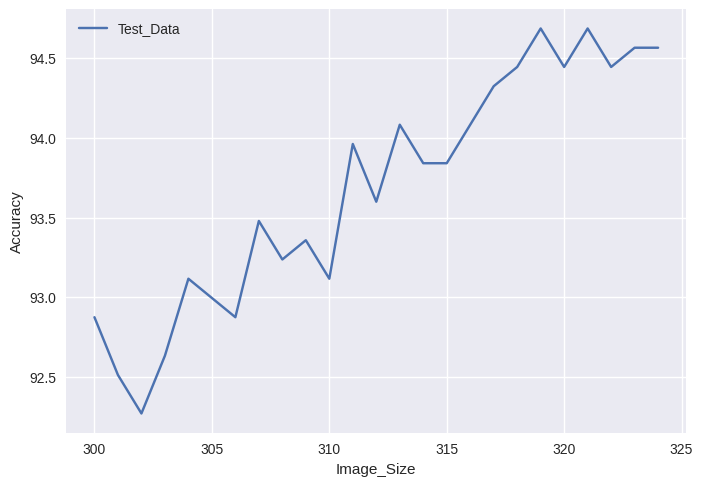

In [ ]:
draw_size_acc(dict_imgSize,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.9412  | 0.696  |  0.8  |          |
|  bcc   |    0.8    | 0.923  | 0.857 |          |
|  bkl   |   0.7654  | 0.939  | 0.844 |          |
|   df   |    0.4    | 0.333  | 0.364 |          |
|  mel   |   0.7931  | 0.676  |  0.73 |          |
|   nv   |   0.9863  | 0.977  | 0.982 |          |
|  vasc  |    1.0    |  0.9   | 0.947 |          |
| Total: |           |        |       |  0.9469  |
+--------+-----------+--------+-------+----------+


In [ ]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

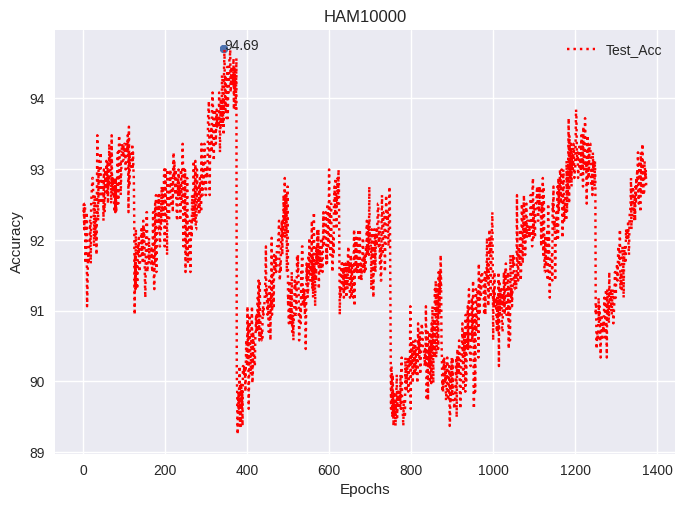

In [ ]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

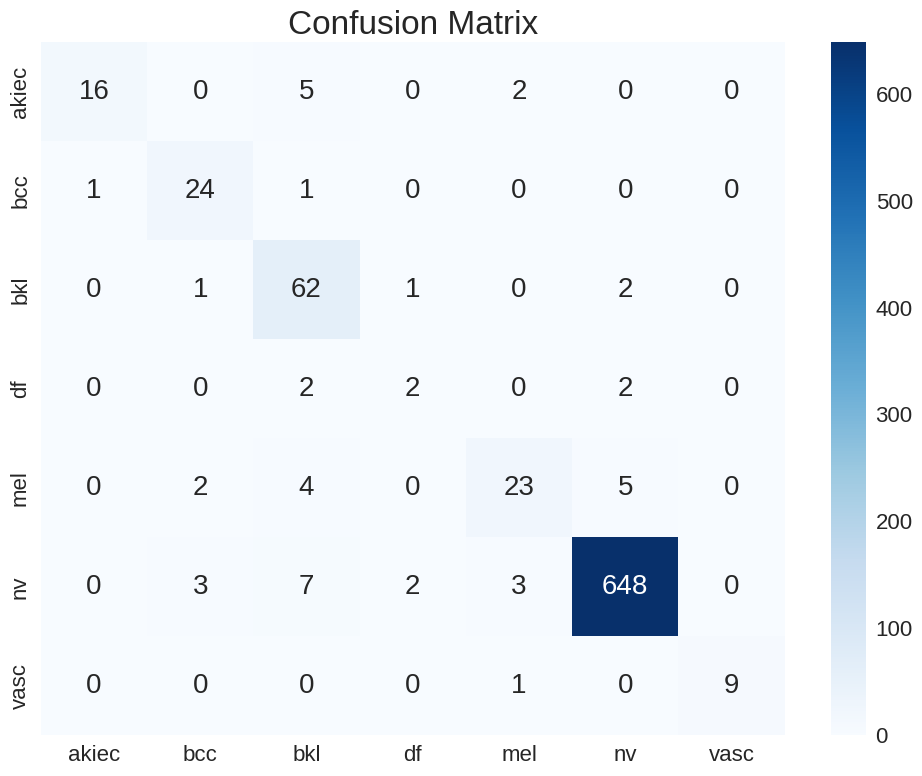

In [ ]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

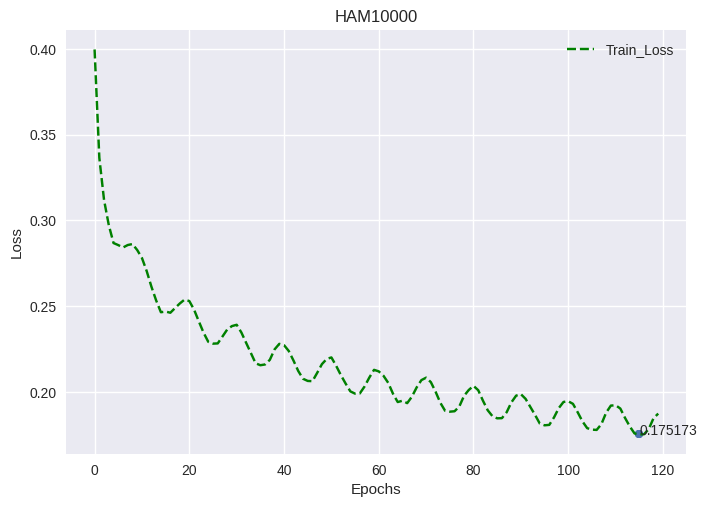

In [ ]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

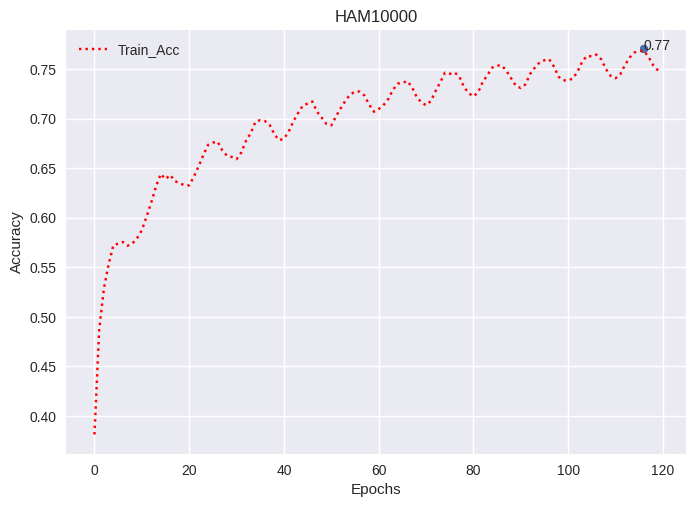

In [ ]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

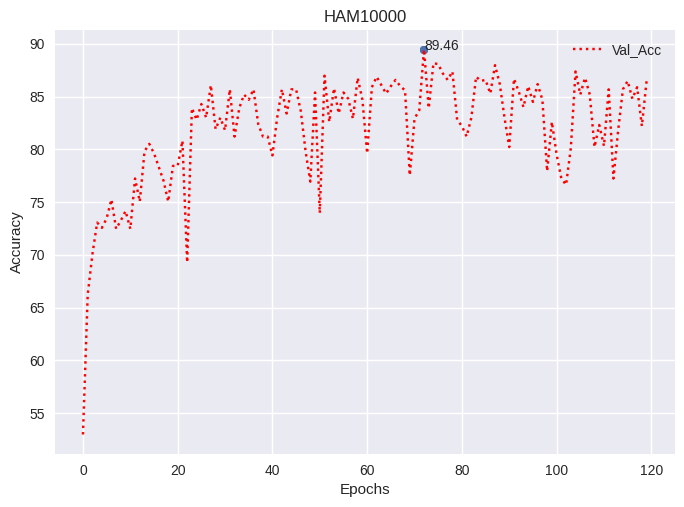

In [ ]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

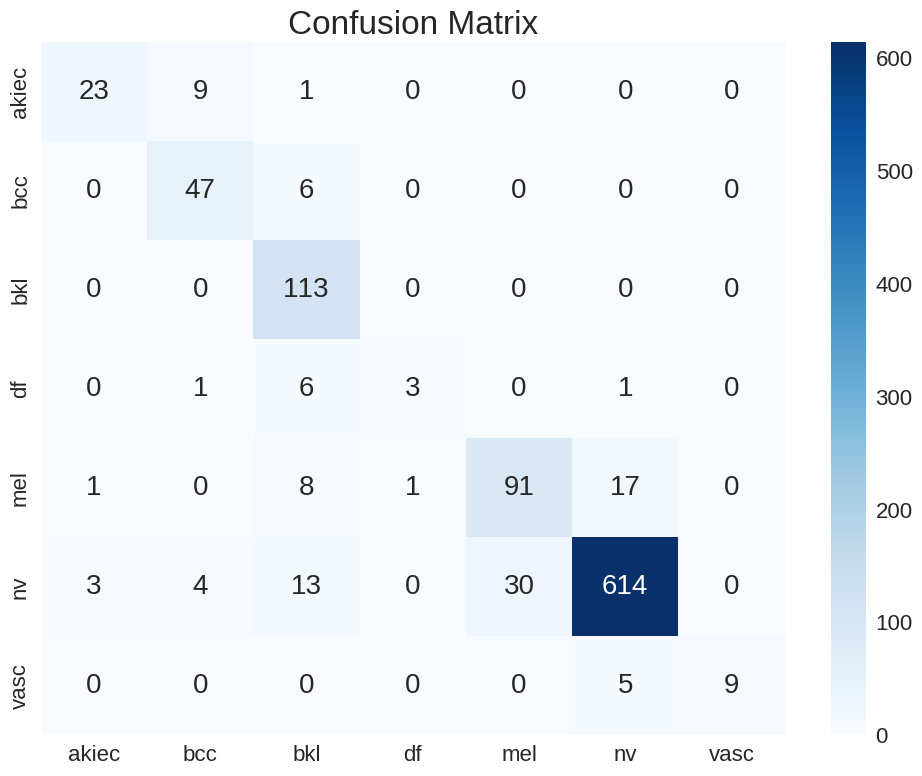

In [ ]:
confusion_matrix(val_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
network.load_state_dict(torch.load(save_PATH))
dict_test = {}
dict_size = {}
test_doc = "test525png384"#"test525png"#
for k in range(23,24):
    T_size = k
    for i in range(301,321):      
        get_data(i)
        print(f"size:{i}")
        for j in range(9):
            test()
            if dict_size.get(i) is None or dict_size[i] < test_acc:
                dict_size[i] = test_acc

                if dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

            elif dict_test.get(k) is None or dict_test[k] < test_acc:
                    dict_test[k] = test_acc

/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:301
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:90.7%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:302
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:90.459%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:303
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.063%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:304
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:305
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:306
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:90.821%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:307
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:90.942%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:308
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.304%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:309
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.184%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:310
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.546%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:311
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.425%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.667%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:312
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:313
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.787%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:314
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:315
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:316
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.237%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:317
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.15%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:91.908%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.029%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:318
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.357%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.271%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:319
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.633%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.874%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.391%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
/content/drive/MyDrive/datasets/HAM100000
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.
size:320
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.754%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:93.116%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.512%
Best_eval:[94.686%]
HAM10000 ==> test ...


  0%|          | 0/36 [00:00<?, ?it/s]

test_Acc:92.995%
Best_eval:[94.686%]


In [ ]:
show.conclusion(img_title=img_title) 
print(sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9])
print(sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [346]
[Test] ACC:94.69%.
[(23, 93.35748553276062)]
[(318, 93.35748553276062), (316, 93.23671460151672), (314, 93.11594367027283), (319, 93.11594367027283), (320, 93.11594367027283), (317, 92.87439584732056), (312, 92.75362491607666), (310, 92.63284802436829), (311, 92.63284802436829)]


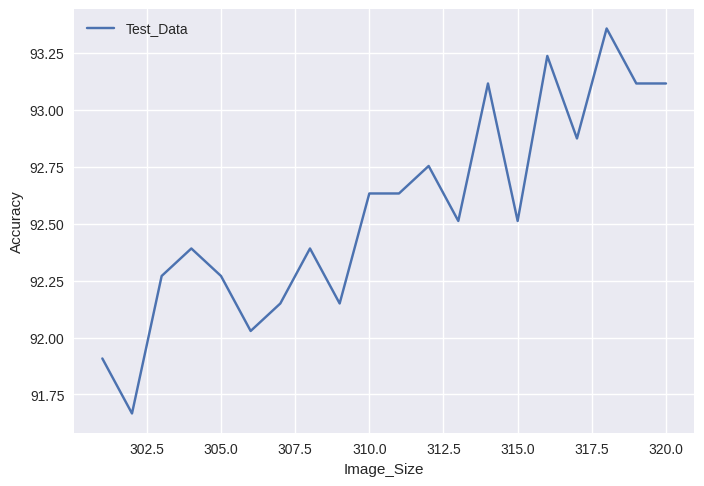

In [ ]:
draw_size_acc(dict_size,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |   0.9412  | 0.696  |  0.8  |          |
|  bcc   |    0.8    | 0.923  | 0.857 |          |
|  bkl   |   0.7654  | 0.939  | 0.844 |          |
|   df   |    0.4    | 0.333  | 0.364 |          |
|  mel   |   0.7931  | 0.676  |  0.73 |          |
|   nv   |   0.9863  | 0.977  | 0.982 |          |
|  vasc  |    1.0    |  0.9   | 0.947 |          |
| Total: |           |        |       |  0.9469  |
+--------+-----------+--------+-------+----------+
